In [106]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
import sys
sys.path.append("C:/git/case7-lockdown-exit-strategy/")

from covid.models.examples.covid import COVID19
from covid.dataset import fetch_daily_case_france,fetch_daily_case_departement,fetch_population
from covid.dataset import fetch_list_available_departements,fetch_bed
from covid.params.utils import read_yaml

# Prepare models

In [91]:
def get_data_dep(dep):
    # Get values
    cases = fetch_daily_case_departement(dep,smooth = True)
    pop = fetch_population(return_data = True).set_index("Départements_ID")
    N_dep = pop.loc[dep,"Ensemble_Total"]
    start_date = cases.index[0]
    init_state = {"S":N_dep-1,"E":1}
    return cases,pop,N_dep,start_date,init_state


class COVID19Departement(COVID19):
    def __init__(self,dep,beta_post = 1.5/4):
        
        params = f"C:/git/case7-lockdown-exit-strategy/notebooks/params/calibration_DEP-{dep}.yaml"
        self.beta_post = beta_post
        self.dep = dep
        self.cases,self.pop,self.N,self.start_date,self.init_state = get_data_dep(dep)
        self.lockdown_start = (pd.to_datetime("2020-03-17") - pd.to_datetime(self.start_date)).days
        print(f"Initialized with N={self.N} and lockdown {self.lockdown_start} after {self.start_date}")
        if params is not None:
            if isinstance(params,str):
                params = read_yaml(params)["calibrated_params"]
            self.reset(params)
        
    def reset(self,params):        
        beta = [params["beta_high"],[params["beta_low"],self.beta_post],[self.lockdown_start - params["offset"],self.lockdown_start - params["offset"] + 57]]
        super().__init__(N = self.N,
            beta = beta,
            offset = params["offset"],
            proba_icu = params["proba_icu"],
            proba_death_hospital = params["proba_death_hospital"],
            recovery_duration_icu = params["recovery_duration_icu"],
            recovery_duration_hospital = params["recovery_duration_hospital"],
            death_duration_hospital = params["death_duration_hospital"],
            death_duration_icu = params["death_duration_icu"],
        )
        
    def show_prediction(self,forecast_days = 0,*args,**kwargs):
        pred = self.predict(forecast_days = forecast_days)
        super().show_prediction(self.cases[["H","ICU","D"]],pred = pred,*args,**kwargs)
        
    def predict(self,forecast_days = 100):
        states = super().predict(self.cases,self.init_state,forecast_days)
        return states

In [ ]:
params = f"C:/git/case7-lockdown-exit-strategy/notebooks/params/calibration_DEP-{dep}.yaml"


In [92]:
dep = COVID19Departement("01")

Initialized with N=656955 and lockdown -1 after 2020-03-18 00:00:00


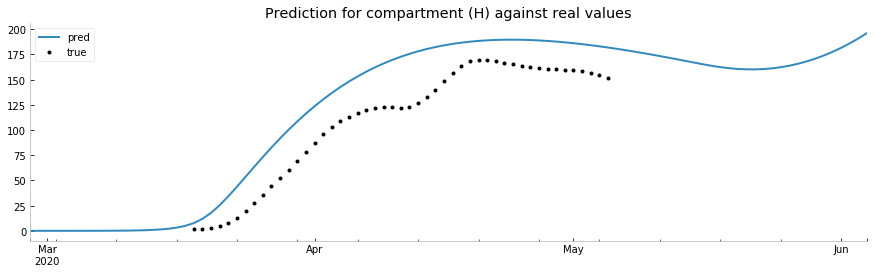

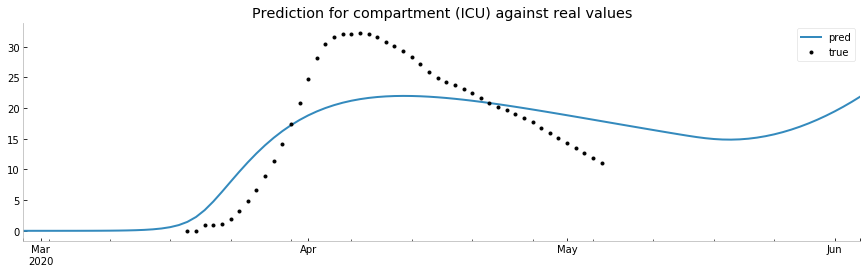

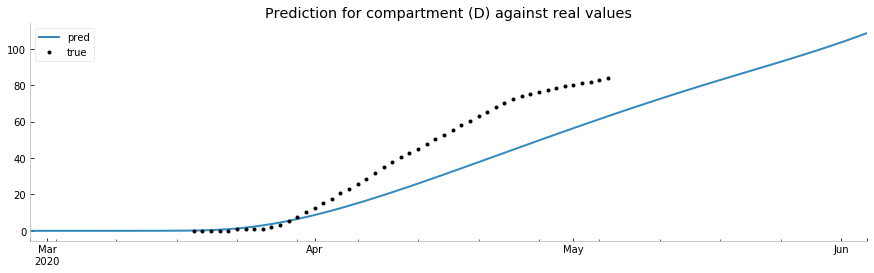

In [93]:
dep.show_prediction(forecast_days = 30)

In [43]:
dep.predict()

,S,E,Ia,Im,Is,H,ICU,D,R
2020-02-28,656954.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-29,656953.783525,0.977890,0.100024,0.105511,0.005694,0.000411,0.000087,0.000001,0.026857
2020-03-01,656953.175911,1.306468,0.195645,0.206377,0.011476,0.001567,0.000324,0.000011,0.102221
2020-03-02,656952.118013,1.963147,0.322070,0.339736,0.019283,0.003580,0.000726,0.000035,0.233409
2020-03-03,656950.416353,3.048983,0.511467,0.539523,0.031007,0.006810,0.001359,0.000086,0.444412
...,...,...,...,...,...,...,...,...,...
2020-08-09,607996.931060,291.636662,149.490564,157.690468,12.260066,43.522857,3.491276,151.394451,48148.582596
2020-08-10,607930.161850,286.180768,146.702219,154.749176,12.031771,42.740565,3.426786,151.771015,48227.235851
2020-08-11,607864.645514,280.823597,143.964017,151.860778,11.807566,41.971234,3.363433,152.140790,48304.423071
2020-08-12,607800.359240,275.563491,141.275127,149.024396,11.587386,41.214694,3.301198,152.503888,48380.170581


# Loop on all departements

In [44]:
all_deps = sorted(fetch_list_available_departements())
beds = fetch_bed(return_data = True)

In [100]:
%%time
all_preds = []
for dep in tqdm_notebook(all_deps):
    try:
        model = COVID19Departement(dep,beta_post=3.3/4)
        pred = model.predict(forecast_days = 50)
        pred["departement"] = dep
        all_preds.append(pred)
    except Exception as e:
        print(f"... Skipped dep {dep} because of {e}")

Initialized with N=656955 and lockdown -1 after 2020-03-18 00:00:00
Initialized with N=526050 and lockdown -1 after 2020-03-18 00:00:00
Initialized with N=331315 and lockdown -1 after 2020-03-18 00:00:00
Initialized with N=165197 and lockdown -1 after 2020-03-18 00:00:00
Initialized with N=141756 and lockdown -1 after 2020-03-18 00:00:00
Initialized with N=1079396 and lockdown -1 after 2020-03-18 00:00:00
Initialized with N=326875 and lockdown -1 after 2020-03-18 00:00:00
Initialized with N=265531 and lockdown -1 after 2020-03-18 00:00:00
Initialized with N=152398 and lockdown -1 after 2020-03-18 00:00:00
Initialized with N=309907 and lockdown -1 after 2020-03-18 00:00:00
Initialized with N=372705 and lockdown -1 after 2020-03-18 00:00:00
Initialized with N=278360 and lockdown -1 after 2020-03-18 00:00:00
Initialized with N=2034469 and lockdown -1 after 2020-03-18 00:00:00
Initialized with N=691453 and lockdown -1 after 2020-03-18 00:00:00
Initialized with N=142811 and lockdown -1 afte

In [101]:
preds = pd.concat(all_preds)
preds

,S,E,Ia,Im,Is,H,ICU,D,R,departement
2020-02-28,656954.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,01
2020-02-29,656953.783525,0.977890,0.100024,0.105511,0.005694,0.000411,0.000087,0.000001,0.026857,01
2020-03-01,656953.175911,1.306468,0.195645,0.206377,0.011476,0.001567,0.000324,0.000011,0.102221,01
2020-03-02,656952.118013,1.963147,0.322070,0.339736,0.019283,0.003580,0.000726,0.000035,0.233409,01
2020-03-03,656950.416353,3.048983,0.511467,0.539523,0.031007,0.006810,0.001359,0.000086,0.444412,01
...,...,...,...,...,...,...,...,...,...,...
2020-06-20,22234.435057,14630.610695,11511.845986,12143.297453,1008.752146,2142.056889,328.044529,28.713944,215443.243301,976
2020-06-21,20746.409432,12706.258774,10392.367786,10962.413276,929.451340,2138.472271,322.187704,30.485687,221242.953731,976
2020-06-22,19491.070065,11002.455993,9330.914478,9842.736791,851.975000,2124.295001,314.646881,32.239226,226480.666563,976
2020-06-23,18430.412243,9503.916660,8336.967229,8794.269229,777.303434,2100.526407,305.666033,33.966149,231187.972616,976


In [102]:
beds_dep = beds[["Code","rea_adultes_public"]].set_index("Code")

def classify_surcapacity(x):
    if x < 0.5:
        return "lightgreen"
    elif x < 1.0:
        return "green"
    elif x < 1.5:
        return "yellow"
    elif x < 3: 
        return "orange"
    else:
        return "red"
    
map_color = {
    "lightgreen":[0, 157, 0],
    "green":[138, 205, 1],
    "yellow":[255, 235, 0],
    "orange":[254, 129, 0],
    "red":[222, 0, 23],
}
    

risk = (pd.DataFrame(preds)
    .loc["2020-05-11":]
    .groupby("departement")[["ICU"]].max()
    .join(beds_dep)
    .assign(surcapacity = lambda x : x["ICU"] / x["rea_adultes_public"])
    .assign(color_code = lambda x : x["surcapacity"].map(classify_surcapacity))
    .assign(color = lambda x : x["color_code"].map(map_color))
)


In [103]:
risk["color_code"].value_counts()

red           85
lightgreen    10
green          3
yellow         2
orange         1
Name: color_code, dtype: int64

## Creation of the map

In [104]:
import json
from covid.visualization.map import show_geojson_pydeck_choropleth

def transform(x,risk_mapping):
    try:
        code = x["code"]
        return risk_mapping[code]
    except:
        return [0,0,0]
    
def add_property(geojson,name,fn):
    for feature in geojson["features"]:
        feature["properties"][name] = fn(feature["properties"])


def create_risk_map(risk,name):
    json_file = "../data/raw/departements.geojson"
    json_data = json.loads(open(json_file,"r").read())
    
    risk_mapping = risk["color"].to_dict()
    add_property(json_data,"color",lambda x : transform(x,risk_mapping))
    risk.to_csv(f"{name}.csv")
    with open(f"{name}.geojson","w") as file:
        json.dump(json_data,file)
    
    return json_data
    
    
json_data = create_risk_map(risk,"level3")

In [105]:
show_geojson_pydeck_choropleth(json_data)

'c:\\git\\case7-lockdown-exit-strategy\\notebooks\\pydeck4c_96wps.html'

# Neptune

In [110]:
dep = "01"
filepath = f"C:/git/case7-lockdown-exit-strategy/notebooks/params/calibration_DEP-{dep}.yaml"

In [111]:
params = read_yaml(filepath)

In [113]:
import neptune

In [114]:
API_TOKEN = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiN2UzMmFhMDAtZWNlMS00M2UyLTlmNDMtZDFmM2M0YmY4ZjkzIn0="

In [115]:
neptune.init('theoalves/covid19-france', api_token=API_TOKEN)

Project(theoalves/covid19-france)

In [130]:
neptune.create_experiment("DEP-01","Simulation pour le département 01",params = params["calibrated_params"],properties = {"département":"01"})

https://ui.neptune.ai/theoalves/covid19-france/e/COV-2


Experiment(COV-2)

In [117]:
neptune.log_metric("loss",0.26)

In [ ]:
neptune.log_image()

In [121]:
np.random.rand(0,100,100)

array([], shape=(0, 100, 100), dtype=float64)

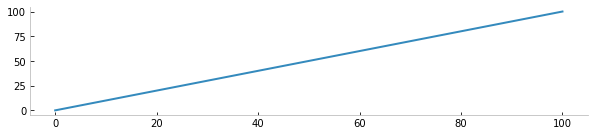

In [131]:
fig = plt.figure(figsize = (10,2))
plt.plot(np.linspace(0,100),np.linspace(0,100))
plt.show()

In [132]:
neptune.log_image("name",plt.gcf())

<Figure size 432x288 with 0 Axes>

In [127]:
neptune.stop()